In [102]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scripts.utils import load_from_pickle
from scipy.stats import chisquare

import seaborn as sns
import matplotlib.pyplot as plt


## Function definitions

In [104]:

def calculate_matrix_orders(arr):
    # get the indices that would sort each row of the array
    sort_indices = np.argsort(-arr, axis=1)

    # create an array to mark the sorted order
    sorted_order = np.empty_like(sort_indices)
    rows, cols = np.indices(arr.shape)
    sorted_order[rows, sort_indices] = cols

    # replace each entry in the original array with its index in the sorted order
    result = sorted_order.astype(int)

    return result



def get_genes_by_factor(res):
    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    genes_by_factors = {}
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors['factor'+str(factor)] = valid_genes
    
    return genes_by_factors


def calculate_phenotype_distributions(df,factor):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = val_counts_background.index

    # The number of cells scoring highest on this factor
    subset = df[df['max_factor'] == factor]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(contig_table)
    print('p-value: ' + str(pval))


def score_modules(ctype, n_comps):
    dat = sc.read_h5ad(ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')
    genes_dict = get_genes_by_factor(res)
    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k)

    # Find the column with the highest score and add a new column for the corresponding factor.
    score_cols = list(genes_dict.keys())
    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_factor'] = max_col

    obs_with_scores = dat.obs.copy()
    del dat

    return(obs_with_scores,genes_dict)

def summarize_factor(df, factor, g_dict):
    n_present = len(np.unique(df[df['max_factor']==factor]['sample']))
    n_dsets = len(np.unique(df[df['max_factor']==factor]['dataset']))
    n_total = len(df['sample'].cat.categories)
    print('Phenotype distribution:')
    calculate_phenotype_distributions(df,factor)
    print('')
    print('Present in '+str(n_present)+' out of '+str(n_total)+
    ' samples and ' + str(n_dsets) + ' datasets.')
    print('')
    print('Top 20 contributing genes:')
    for g in g_dict[factor][:20]:
        print(g)
    
def plot_score_violins(scores_df):
    # Take all columns with factor in their name
    factor_columns = [col for col in scores_df.columns if 'factor' in col]
    # Drop the size_factors column
    factor_columns = [f for f in factor_columns if f != 'size_factors']

    if len(factor_columns) > 0:
        violin_df = scores_df[factor_columns]

        rows = len(factor_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(factor_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x='max_factor', y=factor_columns[i], ax=axs[row][col])

        plt.show()
    else:
        print("No columns found with 'factor' in their names.")




## Loading the NMF gene lists and scoring them

In [3]:
# The number of components used is determined as the highest 
# n that yileds at least 20 unique genes in each component.
# Very similar to the one used in Barkley et al. Nat Genetics 2022

nmf_components_by_ctype = {
    'T_cell': 5,
    'Myeloid': 6,
    'Fibroblast_muscle': 5,
    'Epithelial': 5,
    }

# Create a dataframe for the final annotations 
final_annotations = pd.DataFrame()

In [126]:
# Put them all in a single list and plot the upsetplot
import upsetplot as ups

genes_by_factors = {}
for ctype in nmf_components_by_ctype.keys():
    n_comps = nmf_components_by_ctype[ctype]

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')

    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors[ctype+'_factor'+str(factor)] = valid_genes

ups_data = ups.from_contents(genes_by_factors)
ax_dict = ups.UpSet(ups_data, subset_size='count',show_counts=True).plot()

    

### Epithelial

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

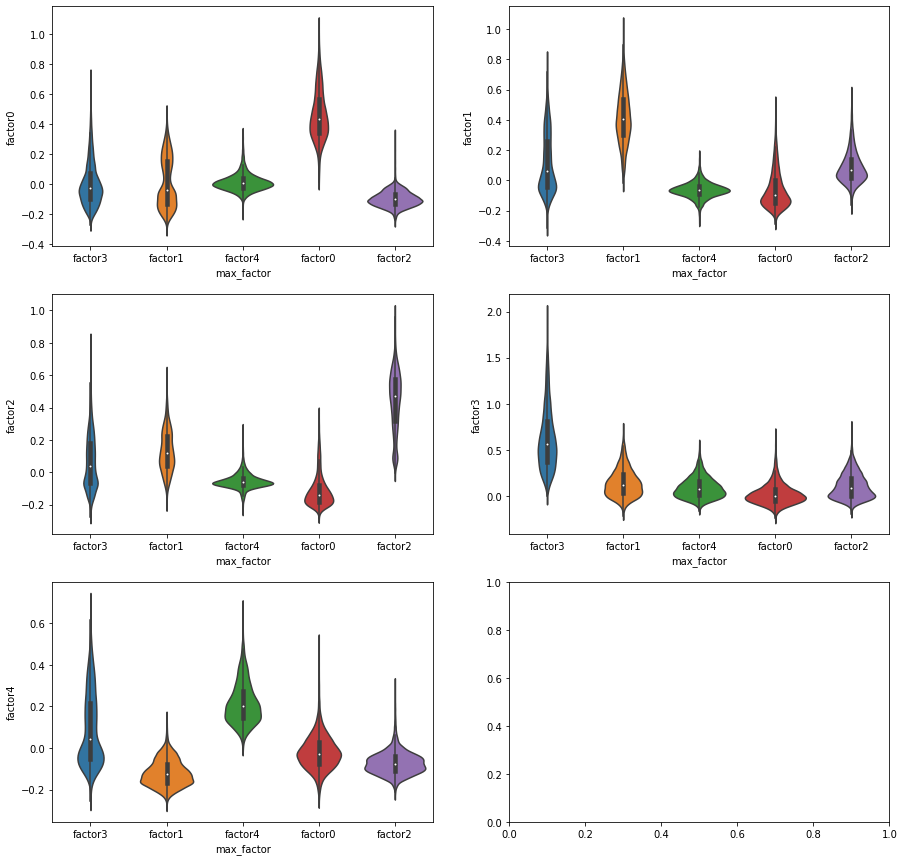

factor3    29410
factor2    19402
factor0    15932
factor1    10734
factor4     6916
Name: max_factor, dtype: int64

In [4]:
scores, genes_dict = score_modules('Epithelial',nmf_components_by_ctype['Epithelial'])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [107]:
g_of_interest = 'FOSB'
for k in genes_dict.keys():
    for i,g in  enumerate(genes_dict[k]):
        if g == g_of_interest:
            print('Its present in '+ k + ' at index '+ str(i))

Its present in factor4 at index 56


In [108]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa        10440     10226  -214
normal      3717       395 -3322
CRPC        1773      5311  3538
p-value: 0.0

Present in 61 out of 97 samples and 7 datasets.

Top 20 contributing genes:
TMSB10
S100A10
S100A16
PPP1R14B
S100A6
HMGA1
KRT7
PHLDA3
SRM
MALL
SFN
SOD2
ITGA2
PHLDA2
S100A14
S100A2
CAV2
S100P
COTL1
GCLM


In [109]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         7034     10178  3144
normal      2504       383 -2121
CRPC        1194       173 -1021
p-value: 0.0

Present in 87 out of 97 samples and 7 datasets.

Top 20 contributing genes:
TRPM4
TMC5
FNIP2
PCA3
OR51E2
AAK1
ARHGEF26
PDLIM5
ERG
DICER1
PRDX2
CLDN8
HPN
GOLM1
FOLH1
VSTM2L
RALGAPA2
TMEM56
AMACR
CREB3L1


In [110]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa        12714      8192 -4522
normal      4527     11138  6611
CRPC        2159        72 -2087
p-value: 0.0

Present in 89 out of 97 samples and 7 datasets.

Top 20 contributing genes:
KLK3
KLK2
AZGP1
SLC45A3
STEAP2
RDH11
NKX3-1
ACPP
FAM213A
AGTRAP
SLC30A4
IDH1
NME4
CKB
RPN2
RCAN3
NDRG1
DBI
PDIA6
TM7SF2


In [111]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa        19273     21319  2046
normal      6862      4696 -2166
CRPC        3273      3395   122
p-value: 2.0329077108162048e-197

Present in 97 out of 97 samples and 7 datasets.

Top 20 contributing genes:
HSPA8
DNAJB1
HSPA1A
PPP1R15A
HSPA1B
DNAJA1
RHOB
RNASEK
ATP6V0C
HSPE1
ZFP36
UBB
PRAC1
HSPH1
IER2
CACYBP
BAG3
JUN
MARCKSL1
NR4A1


In [112]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         4532      4081  -451
normal      1613      2615  1002
CRPC         769       220  -549
p-value: 1.323650623001262e-230

Present in 91 out of 97 samples and 7 datasets.

Top 20 contributing genes:
PDLIM1
DDIT4
ZFP36L1
SGK1
MEIS2
SYNE2
CD82
NBEAL1
KRT15
PYCARD
THSD4
TNFSF10
GJA1
CYP4B1
SLC40A1
ARRDC2
NTN4
FLRT3
PIK3R1
PALLD


In [113]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'prostaglandind active epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'ERG tumor epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'luminal-like epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'stressed epithelium')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'basal-like epithelium')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### T cell

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

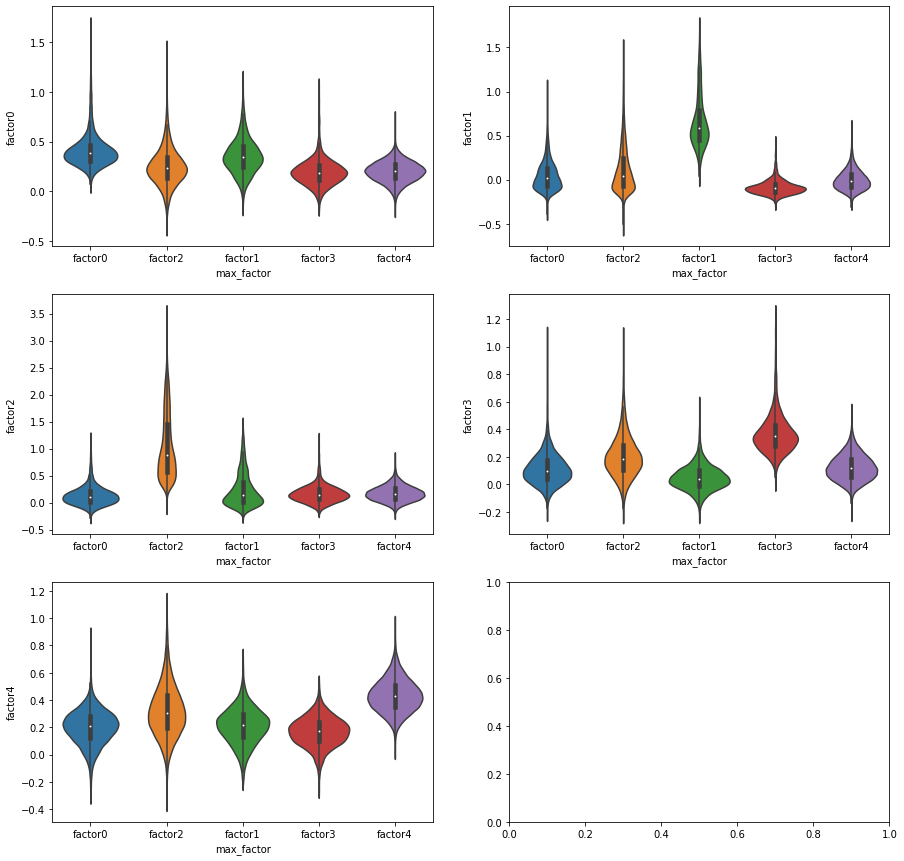

factor2    46393
factor4    36323
factor0    15276
factor3     5251
factor1     4471
Name: max_factor, dtype: int64

In [114]:
scores, genes_dict = score_modules('T_cell',nmf_components_by_ctype['T_cell'])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [115]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         7940      7279  -661
normal      6968      7426   458
CRPC         367       571   204
p-value: 9.443676955310395e-44

Present in 86 out of 96 samples and 7 datasets.

Top 20 contributing genes:
PFN1
TMSB4X
HLA-DRA
MTRNR2L8
HLA-DPB1
PSME2
MTRNR2L12
STMN1
CD8B
CD7
TUBB
HLA-DRB5
TIMP1
HLA-DRB1
MTRNR2L1
HMGN2
HMGB2
RANBP1
GAPDH
HLA-DQA1


In [116]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         2324      2523   199
normal      2039      1837  -202
CRPC         107       111     4
p-value: 8.172355198628455e-09

Present in 78 out of 96 samples and 7 datasets.

Top 20 contributing genes:
CTSW
NKG7
IFITM1
CST7
TYROBP
GNLY
LDHA
FCER1G
EFHD2
CALR
HLA-B
RBM38
PRF1
IL2RB
KLRD1
DNAJC1
KLRF1
RAC1
GZMA
GABARAP


In [117]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa        24115     32514  8399
normal     21162     12110 -9052
CRPC        1115      1769   654
p-value: 0.0

Present in 90 out of 96 samples and 7 datasets.

Top 20 contributing genes:
DNAJB1
DUSP1
HSPA1A
HSPA1B
UBC
PNRC1
CSRNP1
H1FX
HSP90AB1
HSPH1
BTG1
NR4A1
RPL17
DNAJA1
ZFP36L2
JUN
RGCC
PPP1R15A
SLC2A3
PLK3


In [118]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         2729      2244  -485
normal      2395      2905   510
CRPC         126       102   -24
p-value: 4.792836773134386e-44

Present in 68 out of 96 samples and 7 datasets.

Top 20 contributing genes:
BATF
TBC1D4
CD27
LTB
JUNB
TNFRSF18
BIRC3
GADD45B
GADD45A
IL2RA
TSHZ2
GPR183
SLAMF1
MAF
SAT1
TIGIT
ARID5B
TNFRSF4
SELL
ICA1


In [119]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa        18880     11430 -7450
normal     16568     24856  8288
CRPC         873        37  -836
p-value: 0.0

Present in 65 out of 96 samples and 7 datasets.

Top 20 contributing genes:
TOB1
KLRB1
ZFP36
EEF1A1
DDIT4
CCL4
TSC22D3
MRPL1
CCR6
GTF2B
HOPX
CXCR4
ANKRD28
ZC3H12A
DDIT3
CKS2
IL7R
PDCL3
ARL4A
GPR171


In [120]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'cytotoxic T cells')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'natural killer cells')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'stressed T cells')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'regulatory T cells')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'helper T cells')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### Myeloid

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

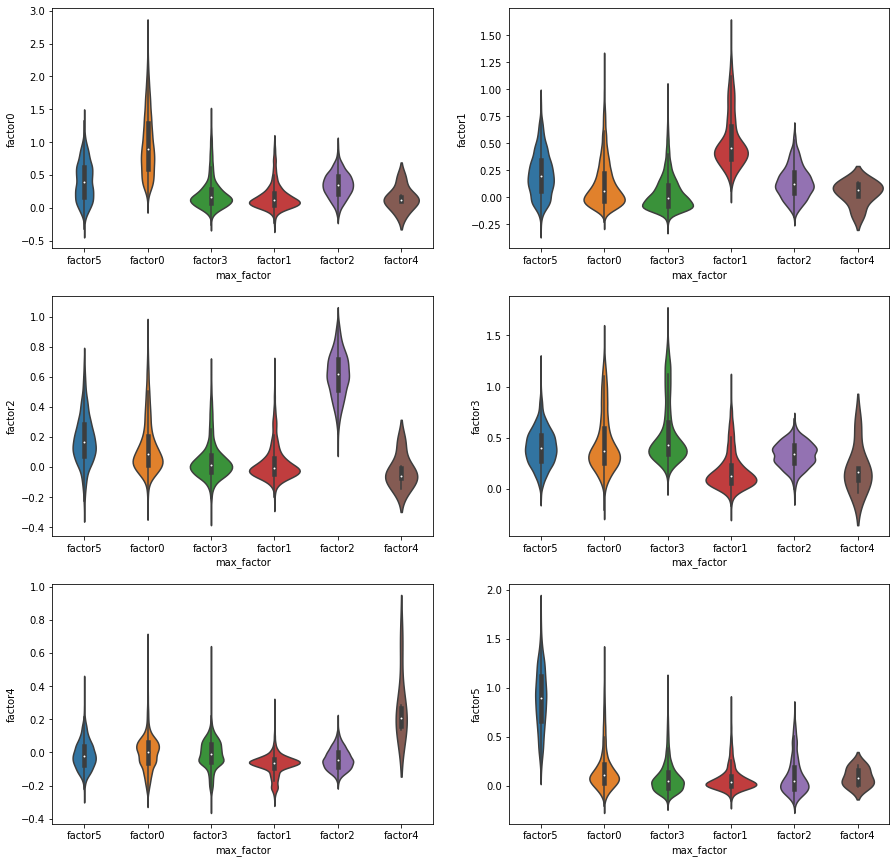

factor0    9901
factor3    8912
factor1    3375
factor5    1952
factor2     895
factor4       6
Name: max_factor, dtype: int64

In [121]:
scores, genes_dict = score_modules('Myeloid',nmf_components_by_ctype['Myeloid'])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [122]:
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         6251      7224   973
normal      3004      2203  -801
CRPC         645       474  -171
p-value: 7.620274930258216e-90

Present in 97 out of 98 samples and 7 datasets.

Top 20 contributing genes:
DNAJB1
HSPA1A
HSPB1
HSPA1B
HSPE1
HSP90AA1
FOS
CACYBP
MRPL18
ZFAND2A
PPP1R15A
HSPA8
HSPD1
UBC
UBB
RHOB
NR4A1
CKS2
IER2
KLF2


In [123]:
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         2130      1745  -385
normal      1024      1521   497
CRPC         219       109  -110
p-value: 1.979752363710773e-80

Present in 87 out of 98 samples and 7 datasets.

Top 20 contributing genes:
SOD2
BCL2A1
PNRC1
PLAUR
S100A4
FTH1
G0S2
IL1B
S100A6
FCN1
LYZ
GK
C5AR1
BTG1
EREG
SLC11A1
SERPINA1
CFP
CXCL2
SERPINB1


In [124]:
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa          565       736   171
normal       271       159  -112
CRPC          58         0   -58
p-value: 9.555066938202768e-35

Present in 24 out of 98 samples and 4 datasets.

Top 20 contributing genes:
CD83
CYBB
BHLHE40
PTGER4
CD81
ARL4C
A2M
PSAP
MAFF
MACF1
NR4A3
KLF6
CYFIP1
CPVL
GRASP
DOCK4
C3
VASH1
OGFRL1
EZR


In [125]:
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         5627      5130  -497
normal      2704      3515   811
CRPC         580       267  -313
p-value: 6.942601494638855e-100

Present in 98 out of 98 samples and 7 datasets.

Top 20 contributing genes:
CD74
ACTB
PKIB
RPL17
GABARAP
TUBA1B
HLA-DRB1
PLD4
PLAC8
TUBB
HLA-DRA
IGFLR1
PPA1
HLA-DQB1
ALOX5AP
COTL1
HMGN2
YWHAH
STMN1
CST3


In [126]:
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa            3         1    -2
normal         1         5     4
CRPC           0         0     0
p-value: 0.01835052705494631

Present in 5 out of 98 samples and 3 datasets.

Top 20 contributing genes:
CD7
CCL5
CD3D
IL32
CD2
CD3E
GIMAP7
ITM2C
IGF1
KLRB1
NKG7
CTSW
GPR82
C1QC
TXNIP
SPON2
LCK
GZMA
CD8A
GPR171


In [127]:
summarize_factor(scores,'factor5',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         1232       975  -257
normal       592       195  -397
CRPC         127       782   655
p-value: 0.0

Present in 86 out of 98 samples and 7 datasets.

Top 20 contributing genes:
FTL
PLD3
CD63
BRI3
LGALS1
APOE
CTSD
ATOX1
APOC1
LGALS3
CSTB
CALM3
CD68
ACP5
TSPAN4
ANXA2
CFD
OTOA
NUPR1
LGMN


In [128]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'stressed myeloids')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'tumor inflammatory monocytes')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'dendritic-like myoeloids')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'antigen-presenting macrophages')
#scores['max_factor'] = scores['max_factor'].replace('factor4', '') # Remove factor 4 since it scores high in so few cells
scores = scores[~(scores['max_factor'] == 'factor4')]
scores['max_factor'] = scores['max_factor'].replace('factor5', 'macrophages')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

### Fibroblasts

/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

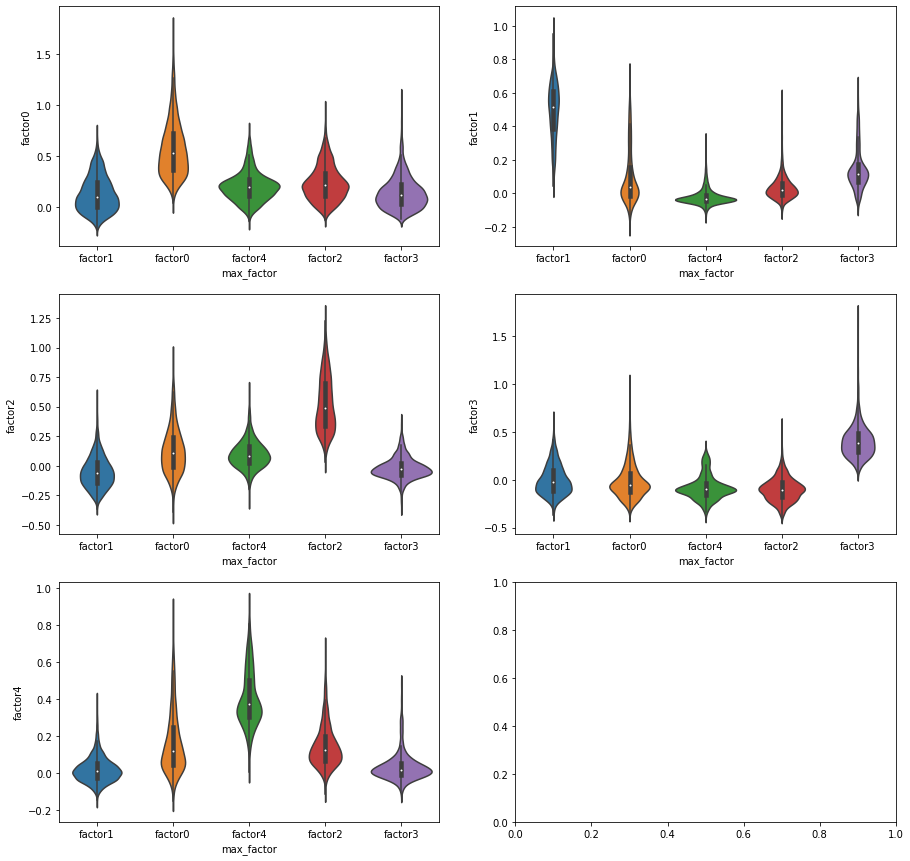

factor0    7311
factor1    4163
factor4    3869
factor2    3595
factor3    1802
Name: max_factor, dtype: int64

In [129]:
ctype = 'Fibroblast_muscle'
scores, genes_dict = score_modules(ctype,nmf_components_by_ctype[ctype])
plot_score_violins(scores)
scores['max_factor'].value_counts()

In [130]:
# Fibroblast_muscle
summarize_factor(scores,'factor0',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         3512      3410  -102
normal      2571      2454  -117
CRPC        1227      1447   220
p-value: 4.2303002691253467e-11

Present in 91 out of 97 samples and 7 datasets.

Top 20 contributing genes:
NR4A1
MAFF
CEBPD
YBX3
FOS
JUN
MT2A
PNRC1
MYC
ZFP36
HSPA1A
NAMPT
CEBPB
IER2
EGR1
SOCS3
HSPA8
ADAMTS4
KRT18
CCL2


In [131]:
# Fibroblast_muscle
summarize_factor(scores,'factor1',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         2000       992 -1008
normal      1464      2044   580
CRPC         698      1127   429
p-value: 6.865475217214415e-218

Present in 83 out of 97 samples and 7 datasets.

Top 20 contributing genes:
RPS29
DCN
TMSB10
S100A13
FBLN1
C1R
SERPINF1
LUM
CTSK
MGP
NPC2
MMP2
SPON2
CST3
MXRA8
C1S
FSTL1
LGALS1
COL1A2
SH3BGRL3


In [132]:
# Fibroblast_muscle
summarize_factor(scores,'factor2',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         1727      2014   287
normal      1264      1056  -208
CRPC         603       525   -78
p-value: 9.487963622515116e-21

Present in 77 out of 97 samples and 7 datasets.

Top 20 contributing genes:
HIGD1B
PLXDC1
NDUFA4L2
COL4A2
CAMK2N1
CCDC102B
SLC12A2
FRMD3
COL18A1
COL4A1
TUBA1B
PROCR
RGS5
NR2F2
IGFBP2
STMN1
UACA
PGF
FOXS1
MARCKSL1


In [133]:
# Fibroblast_muscle
summarize_factor(scores,'factor3',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa          865      1135   270
normal       633       584   -49
CRPC         302        83  -219
p-value: 2.4368460028023553e-54

Present in 71 out of 97 samples and 7 datasets.

Top 20 contributing genes:
PAGE4
HLA-DPA1
GPM6B
PTGDS
HLA-DPB1
RORB
HLA-DRA
CD74
ALDH1A3
PEMT
HLA-DRB1
CD3D
SAT1
CCL5
IGF1
TNFSF10
RNASET2
HLA-DQB1
GPC3
HLA-DMA


In [134]:
# Fibroblast_muscle
summarize_factor(scores,'factor4',genes_dict)

Phenotype distribution:
        expected  observed  diff
PCa         1858      2413   555
normal      1360      1157  -203
CRPC         649       299  -350
p-value: 2.7017611762508127e-84

Present in 85 out of 97 samples and 7 datasets.

Top 20 contributing genes:
TPM2
TAGLN
CNN1
PLN
MYLK
ACTA2
NEXN
SORBS2
NTRK2
NET1
FILIP1
FHL1
LMOD1
MCAM
PPP1R12B
RERGL
CSRP1
MRVI1
SYNPO2
UTRN


In [135]:
# Rename the columns accordingly
scores['max_factor'] = scores['max_factor'].replace('factor0', 'stressed fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor1', 'inflammatory fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor2', 'pericytes')
scores['max_factor'] = scores['max_factor'].replace('factor3', 'antigen presenting fibroblasts')
scores['max_factor'] = scores['max_factor'].replace('factor4', 'myofibroblasts')
final_annotations = pd.concat([final_annotations,scores['max_factor']],axis=0)

## Merging annotations with data

In [136]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [ ]:
adata = sc.read_h5ad('single-cell-reference-subeset-with-broad-annotation.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [138]:
final_annotations

,final_annotation
GSM4711415_P6_AAACGAACACAACGAG.1,stressed epithelium
GSM4711415_P6_AAACGCTTCAGTCTTT.1,stressed epithelium
GSM4711415_P6_AAAGGTACAGATGCGA.1,stressed epithelium
GSM4711415_P6_AAAGGTACATGCGTGC.1,stressed epithelium
GSM4711415_P6_AACAACCGTGAGTAGC.1,ERG tumor epithelium
...,...
SCG-PCA22-T-HG_TTTACTGTCGCTTGTC-1,antigen presenting fibroblasts
SCG-PCA22-T-HG_TTTATGCAGGAATGGA-1,stressed fibroblasts
SCG-PCA22-T-HG_TTTCCTCAGTCTTGCA-1,stressed fibroblasts
SCG-PCA22-T-HG_TTTCCTCCAGTTTACG-1,stressed fibroblasts


In [ ]:
# Subset the adata to only include 

merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')



Done


In [ ]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing Myeloids since there was this 6 cell un-named set of cells
adata = adata[~(adata.obs['final_annotation']=='Myeloid')]


In [ ]:
adata.obs

View of AnnData object with n_obs × n_vars = 283675 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'clusters', 'broad_celltypes', '_scvi_batch', '_scvi_labels', 'VI_clusters', 'to_plot', 'refined_celltypes', 'final_annotation'
    uns: 'VI_clusters_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_VI_clusters', 'dendrogram_refined_celltypes', 'leiden', 'neighbors', 'rank_genes_groups', 'refined_celltypes_colors', 'to_plot_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [200]:
adata.write('./single-cell-reference-with-nmf-derived-annotations-20230519.h5ad')

In [ ]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

stressed T cells                    46393
helper T cells                      36323
stressed epithelium                 29410
Endothelial                         22137
luminal-like epithelium             19402
prostaglandind active epithelium    15932
cytotoxic T cells                   15276
B cell                              13521
ERG tumor epithelium                10734
stressed myeloids                    9901
antigen-presenting macrophages       8912
Mast                                 7891
stressed fibroblasts                 7311
basal-like epithelium                6916
regulatory T cells                   5251
natural killer cells                 4471
inflammatory fibroblasts             4163
myofibroblasts                       3869
pericytes                            3595
tumor inflammatory monocytes         3375
MEG3 epithelial                      2446
macrophages                          1952
antigen presenting fibroblasts       1802
Plasma                            